In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

import os
import time

from tensorflow.keras import layers

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
tf.random.set_seed(267)
np.random.seed(0)

In [5]:
print(train_images.shape)
train_images = train_images[..., np.newaxis].astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(train_images.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [6]:
# create model

In [7]:
# generator

In [8]:
def generator(n_units=128, alpha=0.01, input_size=100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(n_units, use_bias=False, input_shape=(input_size,)))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dense(784, use_bias=False, activation='tanh'))
    model.add(layers.Reshape((28, 28)))
    return model

(1, 28, 28)


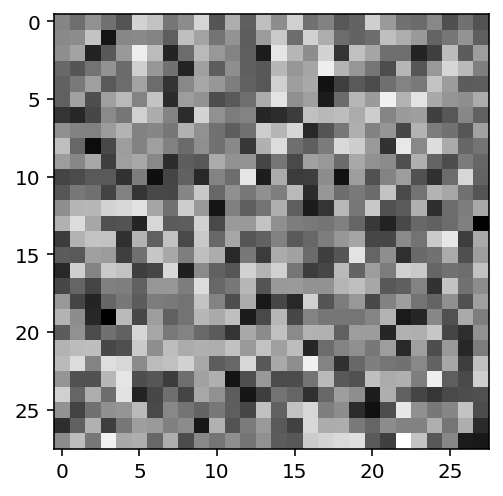

In [9]:
g_model = generator()

noise = tf.random.normal([1,100])
generated_image = g_model(noise, training=False)

print(generated_image.shape)
plt.imshow( generated_image[0], cmap='gray')

In [10]:
# discriminator

In [11]:
def discriminator(n_units=128, alpha=0.01):
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(n_units))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dense(1))    
    return model

In [12]:
d_model = discriminator()
decision = d_model(generated_image)
print (decision)

tf.Tensor([[-0.5010376]], shape=(1, 1), dtype=float32)


In [13]:
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

In [14]:
# Build the model
g_model = generator(n_units=g_hidden_size, alpha=alpha, input_size=z_size)
d_model = discriminator(n_units=d_hidden_size, alpha=alpha)

In [15]:
# Calculate losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(d_logits_real, d_logits_fake):
    d_loss_real = cross_entropy(tf.ones_like(d_logits_real) * (1 - smooth), d_logits_real)
    d_loss_fake = cross_entropy(tf.zeros_like(d_logits_fake), d_logits_fake)
    d_loss_total = d_loss_real + d_loss_fake
    return d_loss_total

def g_loss(d_logits_fake):
    return cross_entropy(tf.ones_like(d_logits_fake), d_logits_fake)

In [16]:
# Optimizers
learning_rate = 0.002

g_train_opt = tf.keras.optimizers.Adam(learning_rate)
d_train_opt = tf.keras.optimizers.Adam(learning_rate)

In [17]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

BUFFER_SIZE = 60000
BATCH_SIZE = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, z_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = g_model(noise, training=True)

        d_logits_real = d_model(images, training=True)
        d_logits_fake = d_model(generated_images, training=True)

        train_loss_g = g_loss(d_logits_fake)
        train_loss_d = d_loss(d_logits_real, d_logits_fake)

    gradients_of_generator = gen_tape.gradient(train_loss_g, g_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(train_loss_d, d_model.trainable_variables)

    g_train_opt.apply_gradients(zip(gradients_of_generator, g_model.trainable_variables))
    d_train_opt.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))
    
    return train_loss_g, train_loss_d

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_train_opt=g_train_opt,
                                 d_train_opt=d_train_opt,
                                 g_model=g_model,
                                 d_model=d_model)

samples = []
losses = []
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_loss_g, train_loss_d = train_step(image_batch)


        print('Time for epoch {}/{} is {} sec...'.format(epoch + 1, epochs, time.time()-start),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        predictions = g_model(sample_z, training=False)
        samples.append(predictions)
        
train(train_dataset, EPOCHS)

Time for epoch 1/100 is 1.8623754978179932 sec... Discriminator Loss: 0.4357... Generator Loss: 3.1194
Time for epoch 2/100 is 1.409820318222046 sec... Discriminator Loss: 0.4676... Generator Loss: 6.6432
Time for epoch 3/100 is 1.4423904418945312 sec... Discriminator Loss: 0.6565... Generator Loss: 3.4343
Time for epoch 4/100 is 1.3789925575256348 sec... Discriminator Loss: 0.4542... Generator Loss: 6.8463
Time for epoch 5/100 is 1.4074275493621826 sec... Discriminator Loss: 0.6981... Generator Loss: 4.0443
Time for epoch 6/100 is 1.3456485271453857 sec... Discriminator Loss: 0.6138... Generator Loss: 4.9518
Time for epoch 7/100 is 1.365098476409912 sec... Discriminator Loss: 0.6560... Generator Loss: 4.0614
Time for epoch 8/100 is 1.428969383239746 sec... Discriminator Loss: 0.9105... Generator Loss: 2.3324
Time for epoch 9/100 is 1.4055492877960205 sec... Discriminator Loss: 0.8271... Generator Loss: 3.0015
Time for epoch 10/100 is 1.4087965488433838 sec... Discriminator Loss: 1.160

Time for epoch 81/100 is 1.5814332962036133 sec... Discriminator Loss: 0.6950... Generator Loss: 4.5329
Time for epoch 82/100 is 1.619234323501587 sec... Discriminator Loss: 0.5876... Generator Loss: 3.2918
Time for epoch 83/100 is 1.5854833126068115 sec... Discriminator Loss: 0.6391... Generator Loss: 4.5965
Time for epoch 84/100 is 1.6045732498168945 sec... Discriminator Loss: 0.7715... Generator Loss: 2.6636
Time for epoch 85/100 is 1.6264300346374512 sec... Discriminator Loss: 0.5878... Generator Loss: 3.4875
Time for epoch 86/100 is 1.6179163455963135 sec... Discriminator Loss: 0.8584... Generator Loss: 3.5229
Time for epoch 87/100 is 1.6482372283935547 sec... Discriminator Loss: 0.5895... Generator Loss: 3.1655
Time for epoch 88/100 is 1.632256269454956 sec... Discriminator Loss: 0.8434... Generator Loss: 3.4687
Time for epoch 89/100 is 1.6498277187347412 sec... Discriminator Loss: 0.7339... Generator Loss: 3.8584
Time for epoch 90/100 is 1.645897388458252 sec... Discriminator Lo

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

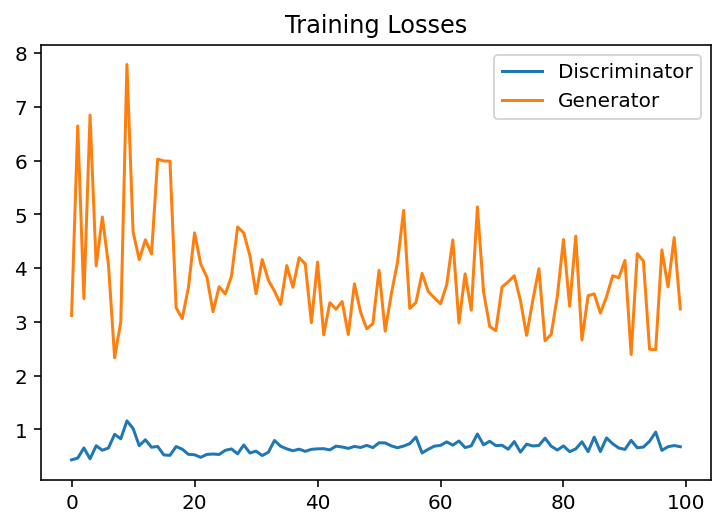

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [22]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.numpy().reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

100
(16, 28, 28)


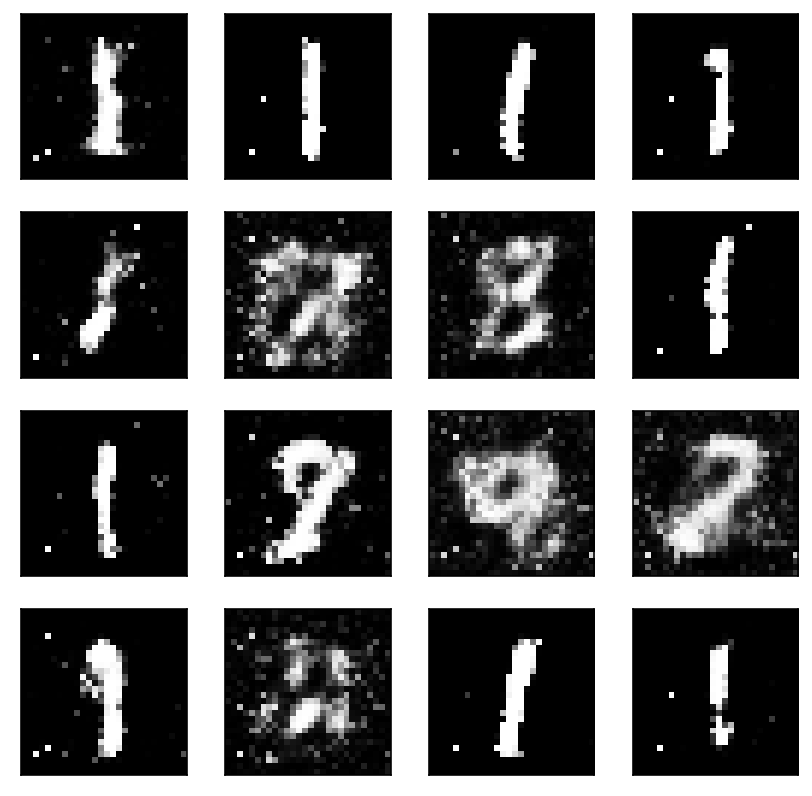

In [23]:
print(len(samples))
print(samples[-1].shape)
_ = view_samples(-1, samples)

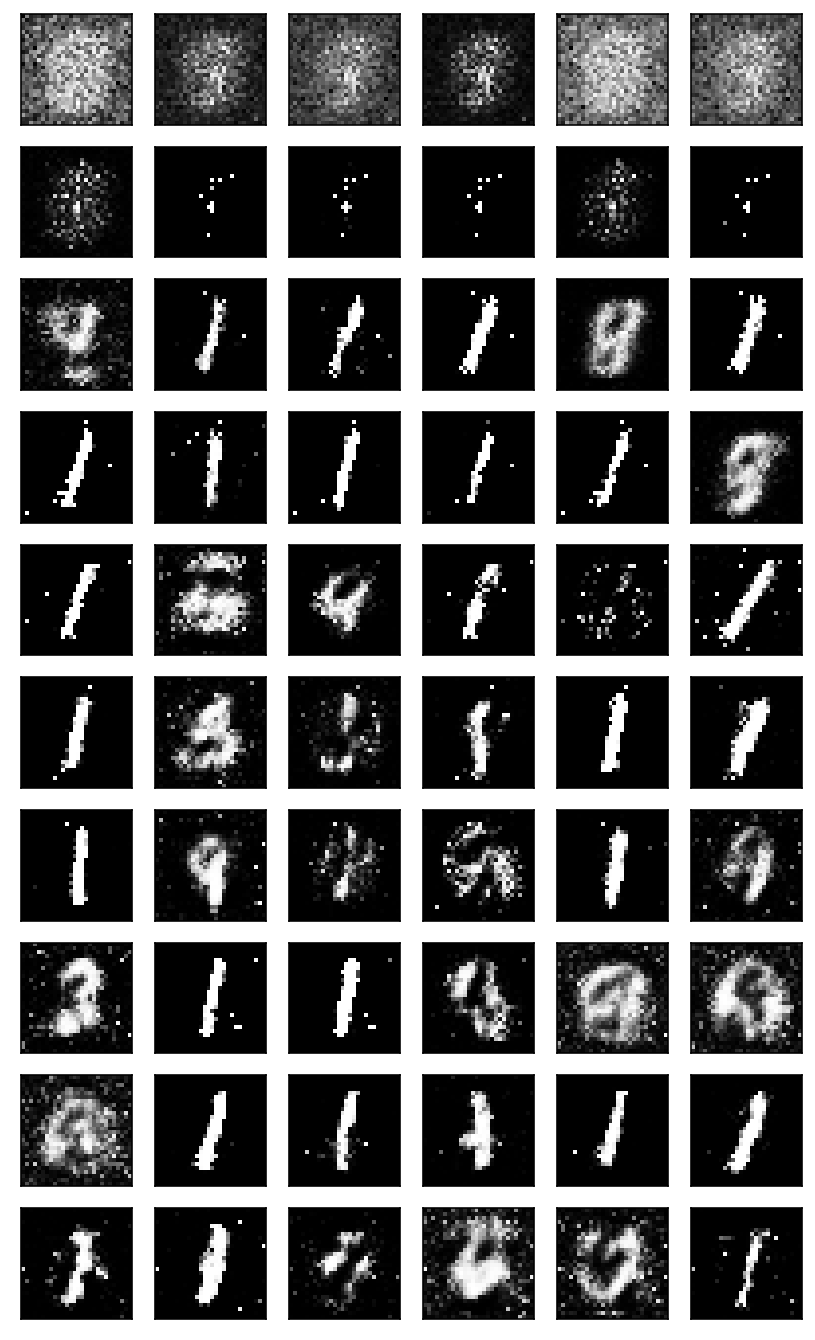

In [24]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.numpy().reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

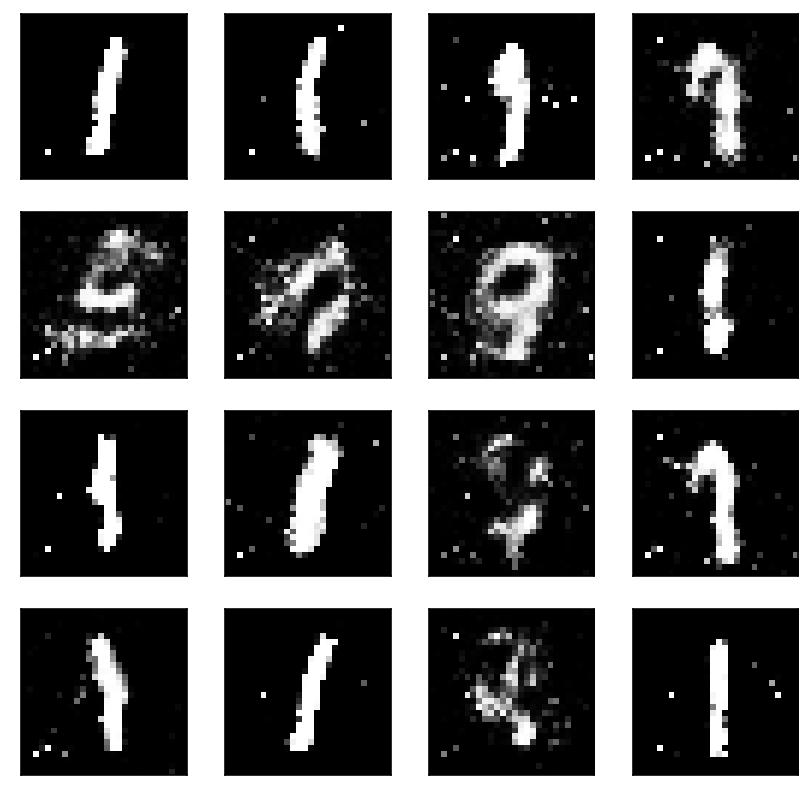

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
sample_z = tf.random.normal([num_examples_to_generate, z_size])
sample_z = np.random.uniform(-1, 1, size=(16, z_size))
gen_samples = g_model(sample_z, training=False)
# samples.append(predictions)
_ = view_samples(-1, [gen_samples])